In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from scipy.stats import mstats

EDA

In [48]:
# Reading the dataframe
df = pd.read_csv("Loan_Default_Data.csv")
df.head()


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0


In [49]:
# Checking Number of rows and columns
df.shape

(40000, 33)

In [50]:
# Checking Number of unique rows in each column
df.nunique()

ID                           40000
year                             1
loan_limit                       2
Gender                           4
approv_in_adv                    2
loan_type                        3
loan_purpose                     4
Credit_Worthiness                2
open_credit                      2
business_or_commercial           2
loan_amount                    173
rate_of_interest               106
Interest_rate_spread         14988
Upfront_charges              18369
term                            23
Neg_ammortization                2
interest_only                    2
lump_sum_payment                 2
property_value                 295
construction_type                2
occupancy_type                   3
Secured_by                       2
total_units                      4
income                         695
credit_type                      4
Credit_Score                   401
co-applicant_credit_type         2
age                              7
submission_of_applic

1. Similarly, the ID column has 40000 unique records, which are the total number of rows, hence it is not significant for our model.
2. It can be observed that the 'year' column has only one unique value, which is 2019. Since the data is of only one year, we can exclude this column for our model.

In [51]:
# Dropping 'year' and 'ID' columns
df.drop(columns=['year', 'ID'], axis = 1, inplace = True)
df.columns

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'construction_type',
       'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type',
       'Credit_Score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status'],
      dtype='object')

In [52]:
# Checking info of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_limit                 39110 non-null  object 
 1   Gender                     40000 non-null  object 
 2   approv_in_adv              39769 non-null  object 
 3   loan_type                  40000 non-null  object 
 4   loan_purpose               39971 non-null  object 
 5   Credit_Worthiness          40000 non-null  object 
 6   open_credit                40000 non-null  object 
 7   business_or_commercial     40000 non-null  object 
 8   loan_amount                40000 non-null  int64  
 9   rate_of_interest           30266 non-null  float64
 10  Interest_rate_spread       30209 non-null  float64
 11  Upfront_charges            29429 non-null  float64
 12  term                       39987 non-null  float64
 13  Neg_ammortization          39971 non-null  obj

1. There are both categorical columns with type = 'object' and numeric columns.
2. Many columns show lesser non-null records than the total number of rows (40,000), hence, these null values need to be handled.

In [53]:
# Storing numerical and categorical columns into new variables for easier use
cat_cols = []
num_cols = []
for i in df.columns:
    if(df[i].dtype == "object"):
        cat_cols.append(i)
    else:
        num_cols.append(i)
print(f"Categorical Columns:\n {cat_cols}\n")
print(f"Number of Categorical columns: {len(cat_cols)}\n")
print(f"Numerical Columns:\n {num_cols}\n")
print(f"Number of Categorical columns: {len(num_cols)}")

Categorical Columns:
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']

Number of Categorical columns: 21

Numerical Columns:
 ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status']

Number of Categorical columns: 10


In [54]:
# 'Status' is our target variable and is already encoded as 0 & 1, hence it need not be considered as a numerical variable
# Thus, dropping status from our numerical columns and creating df_target for the 'Status' column

num_cols = num_cols[:-1]
print(f'Numeric Columns: {num_cols}')

df_target = df['Status'].copy()
df_target.head()

Numeric Columns: ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV']


0    1
1    1
2    0
3    0
4    0
Name: Status, dtype: int64

Dealing with Categorical Columns

In [55]:
# Checking value counts for each categorical variable
for i in cat_cols:
    print(f"{i}:\n{df[i].value_counts()}")

loan_limit:
cf     36397
ncf     2713
Name: loan_limit, dtype: int64
Gender:
Male                 11402
Joint                11032
Sex Not Available    10034
Female                7532
Name: Gender, dtype: int64
approv_in_adv:
nopre    33516
pre       6253
Name: approv_in_adv, dtype: int64
loan_type:
type1    30479
type2     5575
type3     3946
Name: loan_type, dtype: int64
loan_purpose:
p3    15146
p4    14687
p1     9265
p2      873
Name: loan_purpose, dtype: int64
Credit_Worthiness:
l1    38332
l2     1668
Name: Credit_Worthiness, dtype: int64
open_credit:
nopc    39867
opc       133
Name: open_credit, dtype: int64
business_or_commercial:
nob/c    34425
b/c       5575
Name: business_or_commercial, dtype: int64
Neg_ammortization:
not_neg    35867
neg_amm     4104
Name: Neg_ammortization, dtype: int64
interest_only:
not_int     38169
int_only     1831
Name: interest_only, dtype: int64
lump_sum_payment:
not_lpsm    39138
lpsm          862
Name: lump_sum_payment, dtype: int64
constructi

In [56]:
# Checking number of null values in categorical columns
df[cat_cols].isnull().sum()

loan_limit                   890
Gender                         0
approv_in_adv                231
loan_type                      0
loan_purpose                  29
Credit_Worthiness              0
open_credit                    0
business_or_commercial         0
Neg_ammortization             29
interest_only                  0
lump_sum_payment               0
construction_type              0
occupancy_type                 0
Secured_by                     0
total_units                    0
credit_type                    0
co-applicant_credit_type       0
age                           57
submission_of_application     57
Region                         0
Security_Type                  0
dtype: int64

In [57]:
# Imputing categorical variables with their mode
df_cat = df[cat_cols].copy()
for i in cat_cols:
    mode = df[i].mode()[0]
    df_cat.loc[:, i].fillna(mode, inplace = True)

df_cat.isnull().sum()


loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
credit_type                  0
co-applicant_credit_type     0
age                          0
submission_of_application    0
Region                       0
Security_Type                0
dtype: int64

In [58]:
# Encoding categorical columns
label = LabelEncoder()
for i in cat_cols:
    if df_cat[i].dtype == 'object':
        df_cat[i] = label.fit_transform(df_cat[i])

df_cat.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,Neg_ammortization,interest_only,...,construction_type,occupancy_type,Secured_by,total_units,credit_type,co-applicant_credit_type,age,submission_of_application,Region,Security_Type
0,0,3,0,0,0,0,0,1,1,1,...,1,1,0,0,3,0,0,1,3,1
1,0,2,0,1,0,0,0,0,1,1,...,1,1,0,0,2,1,3,1,0,1
2,0,2,1,0,0,0,0,1,0,1,...,1,1,0,0,3,0,1,1,3,1
3,0,2,0,0,3,0,0,1,1,1,...,1,1,0,0,3,0,2,0,0,1
4,0,1,1,0,0,0,0,1,1,1,...,1,1,0,0,1,1,0,0,0,1


Dealing with Numeric Columns

In [59]:
# Describing numerical columns
df_num = df[num_cols].copy()
df_num.describe()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV
count,4.000000e+04,30266.000000,30209.000000,29429.000000,39987.000000,3.592300e+04,37613.000000,40000.000000,35923.000000
mean,3.319168e+05,4.045684,0.438373,3256.072052,335.307675,4.979067e+05,6935.976391,700.127475,72.850638
std,1.831009e+05,0.557585,0.511520,3277.750009,58.052335,3.611681e+05,6404.227585,115.789976,45.017506
min,2.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,2.813745
25%,1.965000e+05,3.625000,0.074100,594.750000,360.000000,2.680000e+05,3720.000000,600.000000,60.658915
50%,2.965000e+05,3.990000,0.386800,2605.080000,360.000000,4.180000e+05,5760.000000,700.000000,75.152439
75%,4.365000e+05,4.375000,0.764000,4874.500000,360.000000,6.280000e+05,8460.000000,801.000000,86.005435
max,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,377220.000000,900.000000,7831.250000


In [60]:
# Checking for null values in each column
df_num.isnull().sum()

loan_amount                 0
rate_of_interest         9734
Interest_rate_spread     9791
Upfront_charges         10571
term                       13
property_value           4077
income                   2387
Credit_Score                0
LTV                      4077
dtype: int64

In [61]:
# Imputing missing values of numerical columns through KNN imputer
knn = KNNImputer(n_neighbors = 3)
knn.fit(df_num)
X = knn.fit_transform(df_num)
df_num = pd.DataFrame(X, columns=num_cols)
df_num.isnull().sum()

loan_amount             0
rate_of_interest        0
Interest_rate_spread    0
Upfront_charges         0
term                    0
property_value          0
income                  0
Credit_Score            0
LTV                     0
dtype: int64

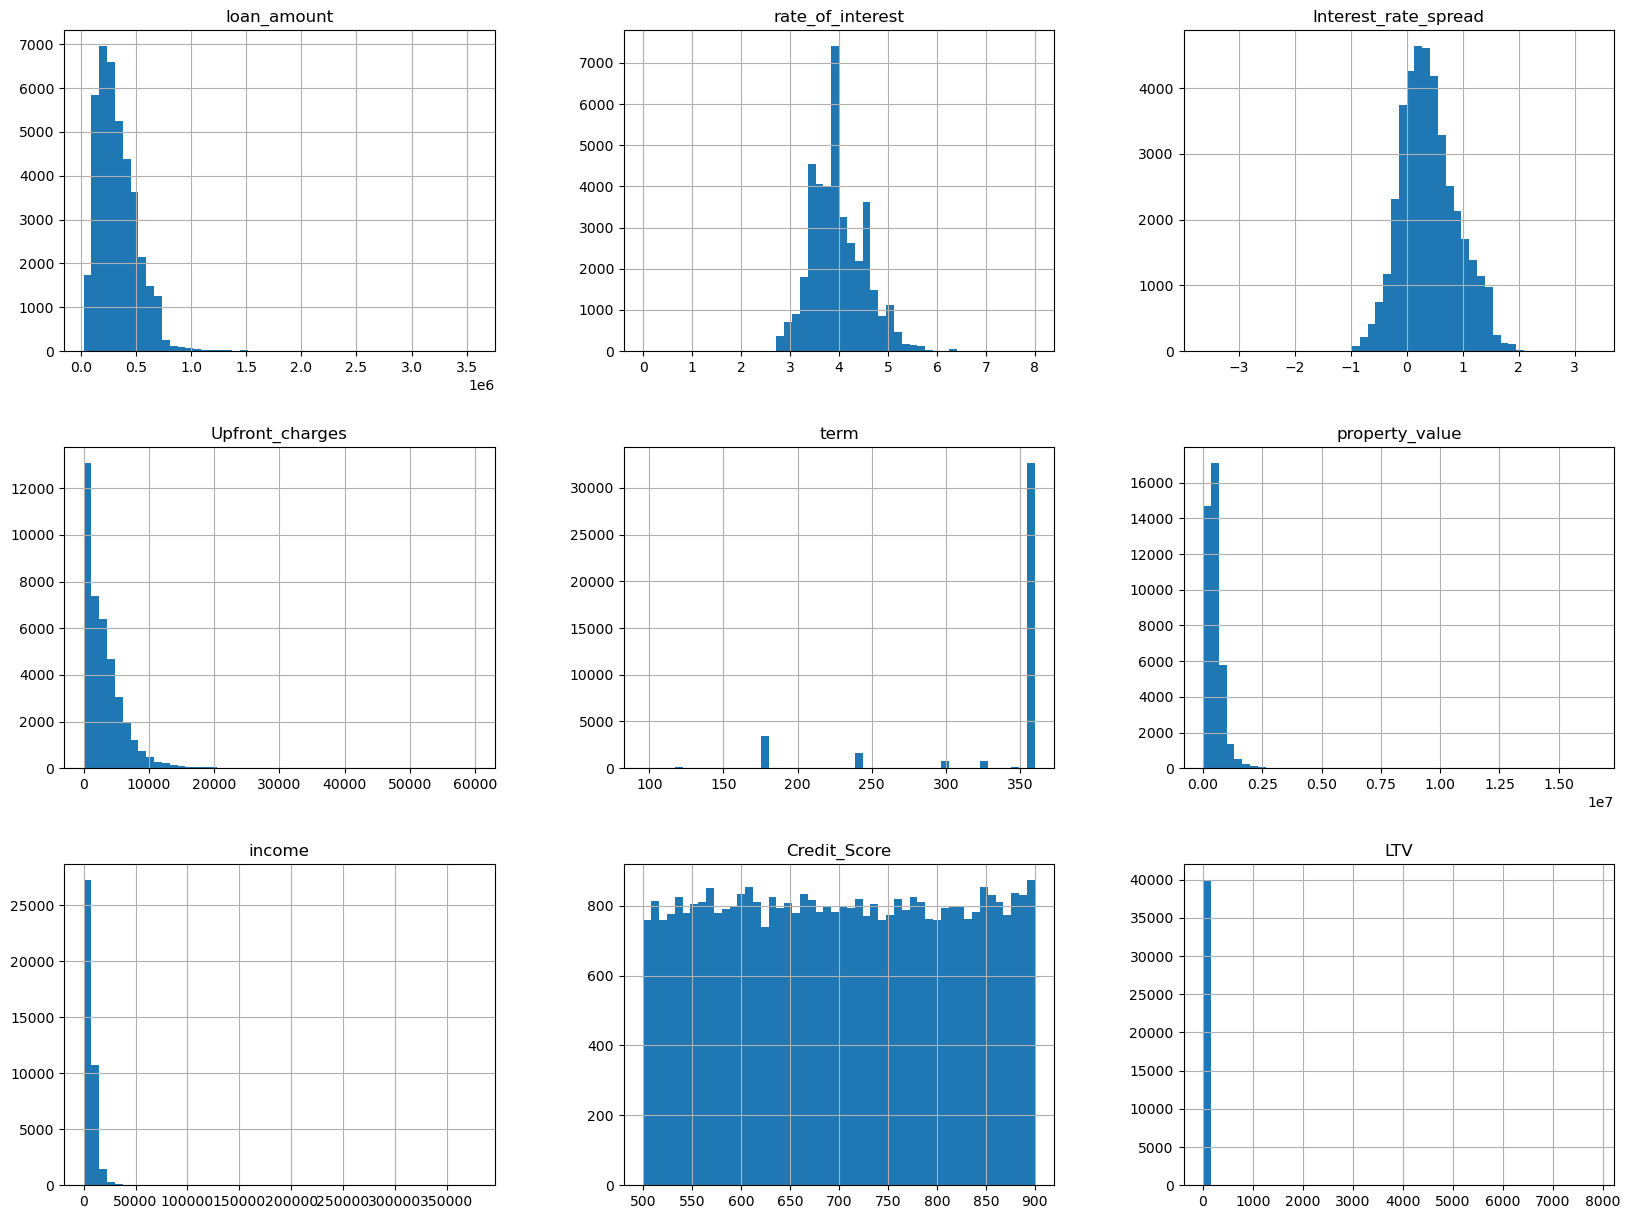

In [62]:
# Histograms for numeric columns
df_num.hist(bins=50,figsize=(20,15))
plt.show()

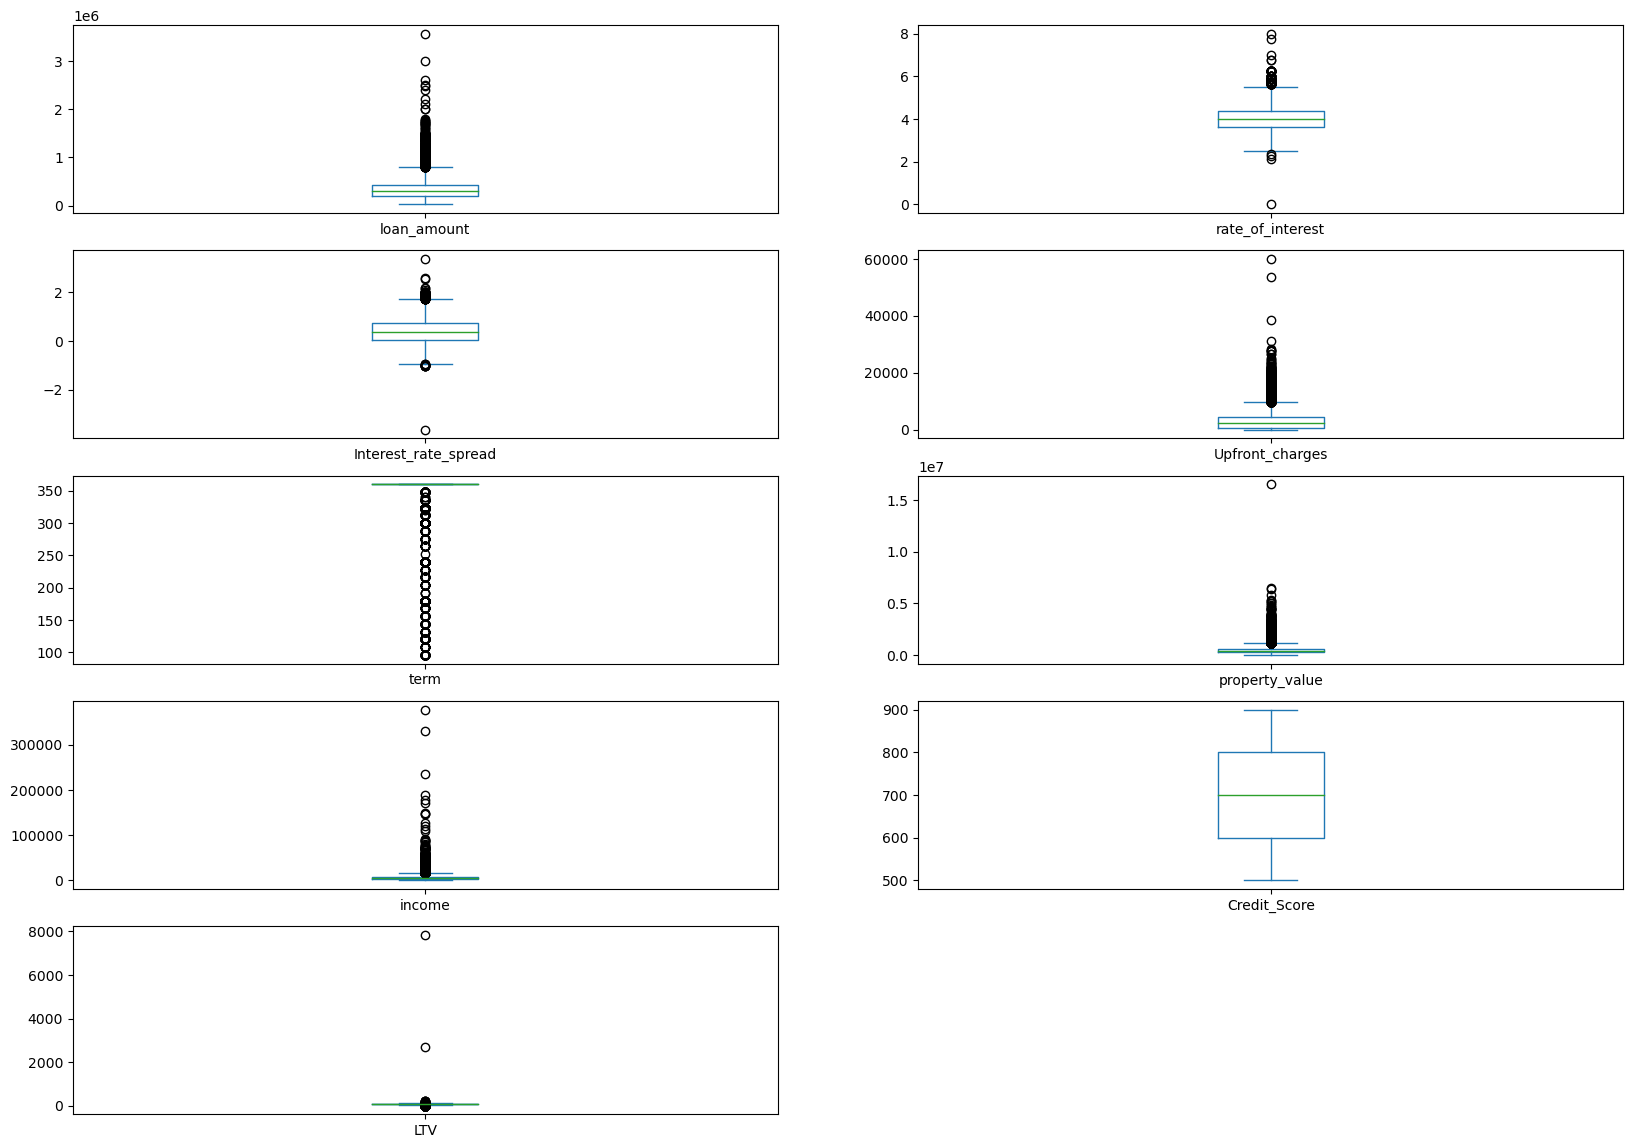

In [63]:
# Box plot for numerical columns to study outliers
df_num.plot(kind="box",subplots=True,layout=(7,2),figsize=(20,20))
plt.show()

In [64]:
# Removing Outliers
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    upper_bound = iqr + np.percentile(df[field_name], 75)
    lower_bound = np.percentile(df[field_name], 25) - iqr

    if ((df[field_name] > upper_bound) | (df[field_name] < lower_bound)).empty:
        print("No outliers to drop.")
        return

    df.drop(df[(df[field_name] > upper_bound) | (df[field_name] < lower_bound)].index, inplace=True)


df_num_copy = df_num.copy()
drop_outliers(df_num_copy, "loan_amount")
drop_outliers(df_num_copy, "rate_of_interest")
drop_outliers(df_num_copy, "Interest_rate_spread")
drop_outliers(df_num_copy, "Upfront_charges")
drop_outliers(df_num_copy, "property_value")
drop_outliers(df_num_copy, "income")
drop_outliers(df_num_copy, "LTV")
drop_outliers(df_num_copy, "term")


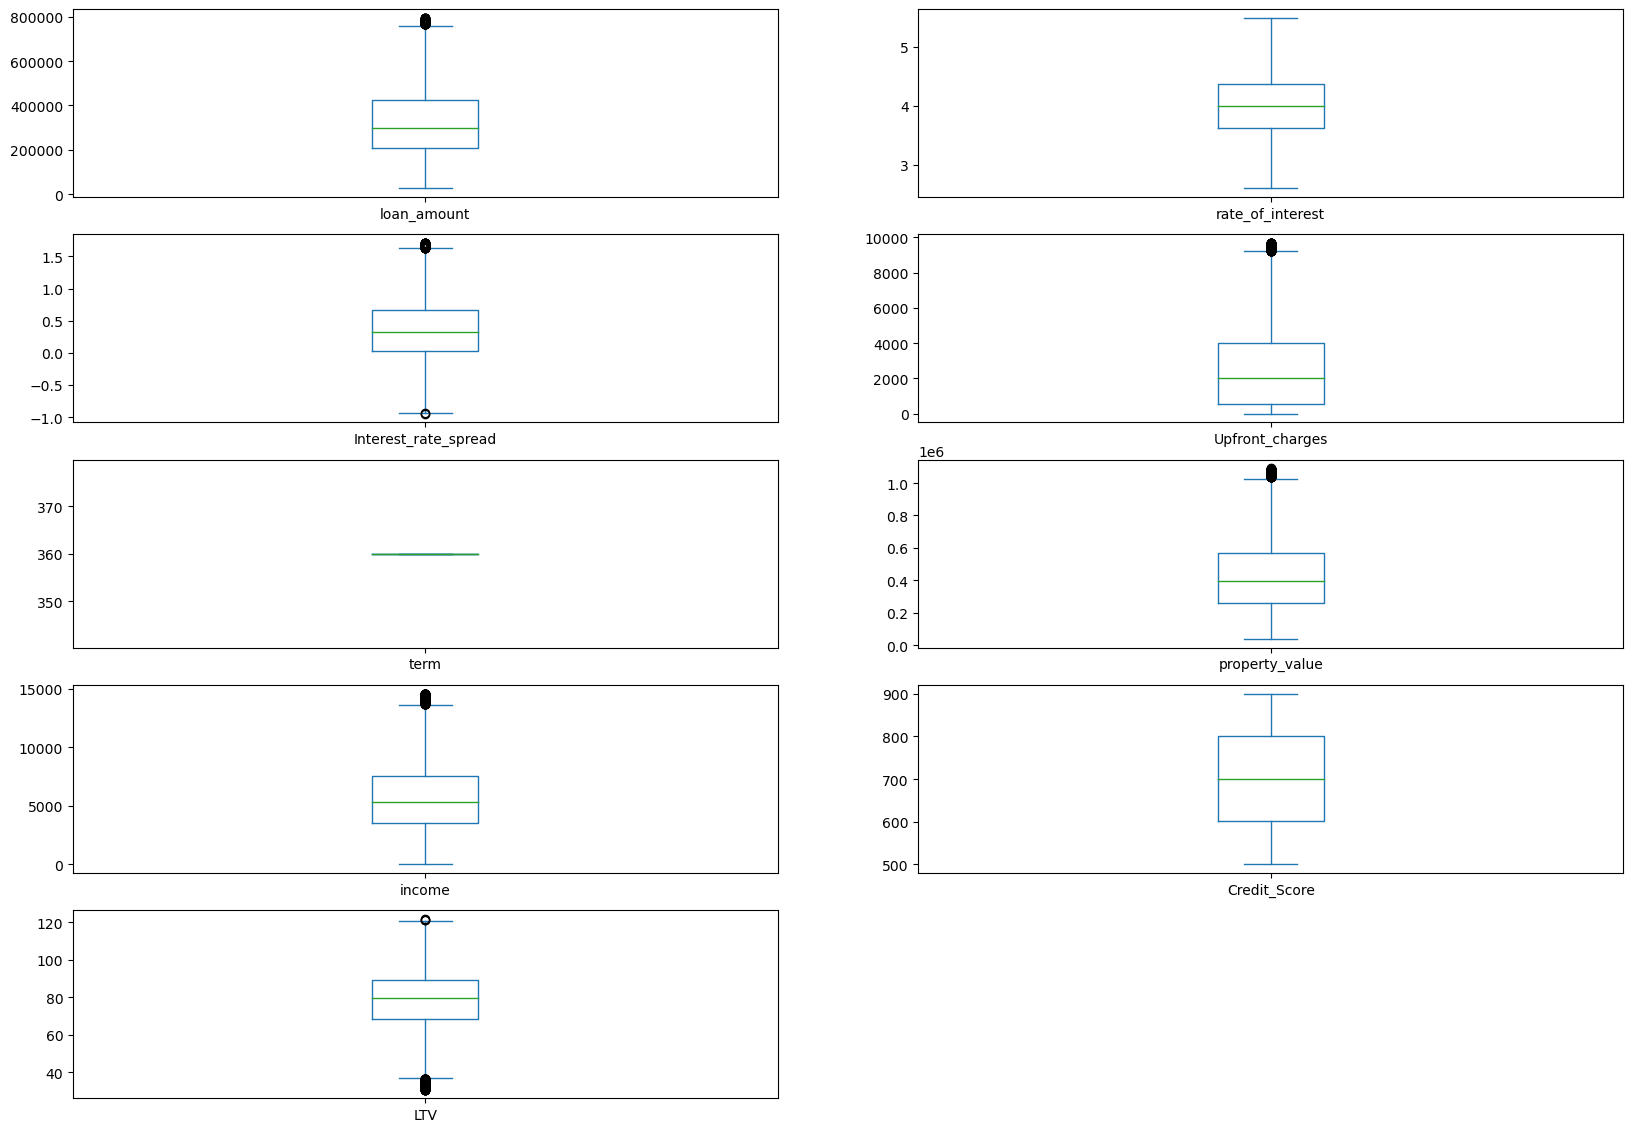

In [65]:
# Box plots after removing outliers
df_num_copy.plot(kind="box",subplots=True,layout=(7,2),figsize=(20,20))
plt.show()

In [66]:
# Checking shape of dataframe after removing outliers
df_num_copy.shape

(28263, 9)

In [67]:
# Winsorizing outliers
df_num_wins = df_num.copy()
for i in num_cols:
    df_num_wins[i] = mstats.winsorize(df_num_wins[i], limits = [0.05, 0.05])


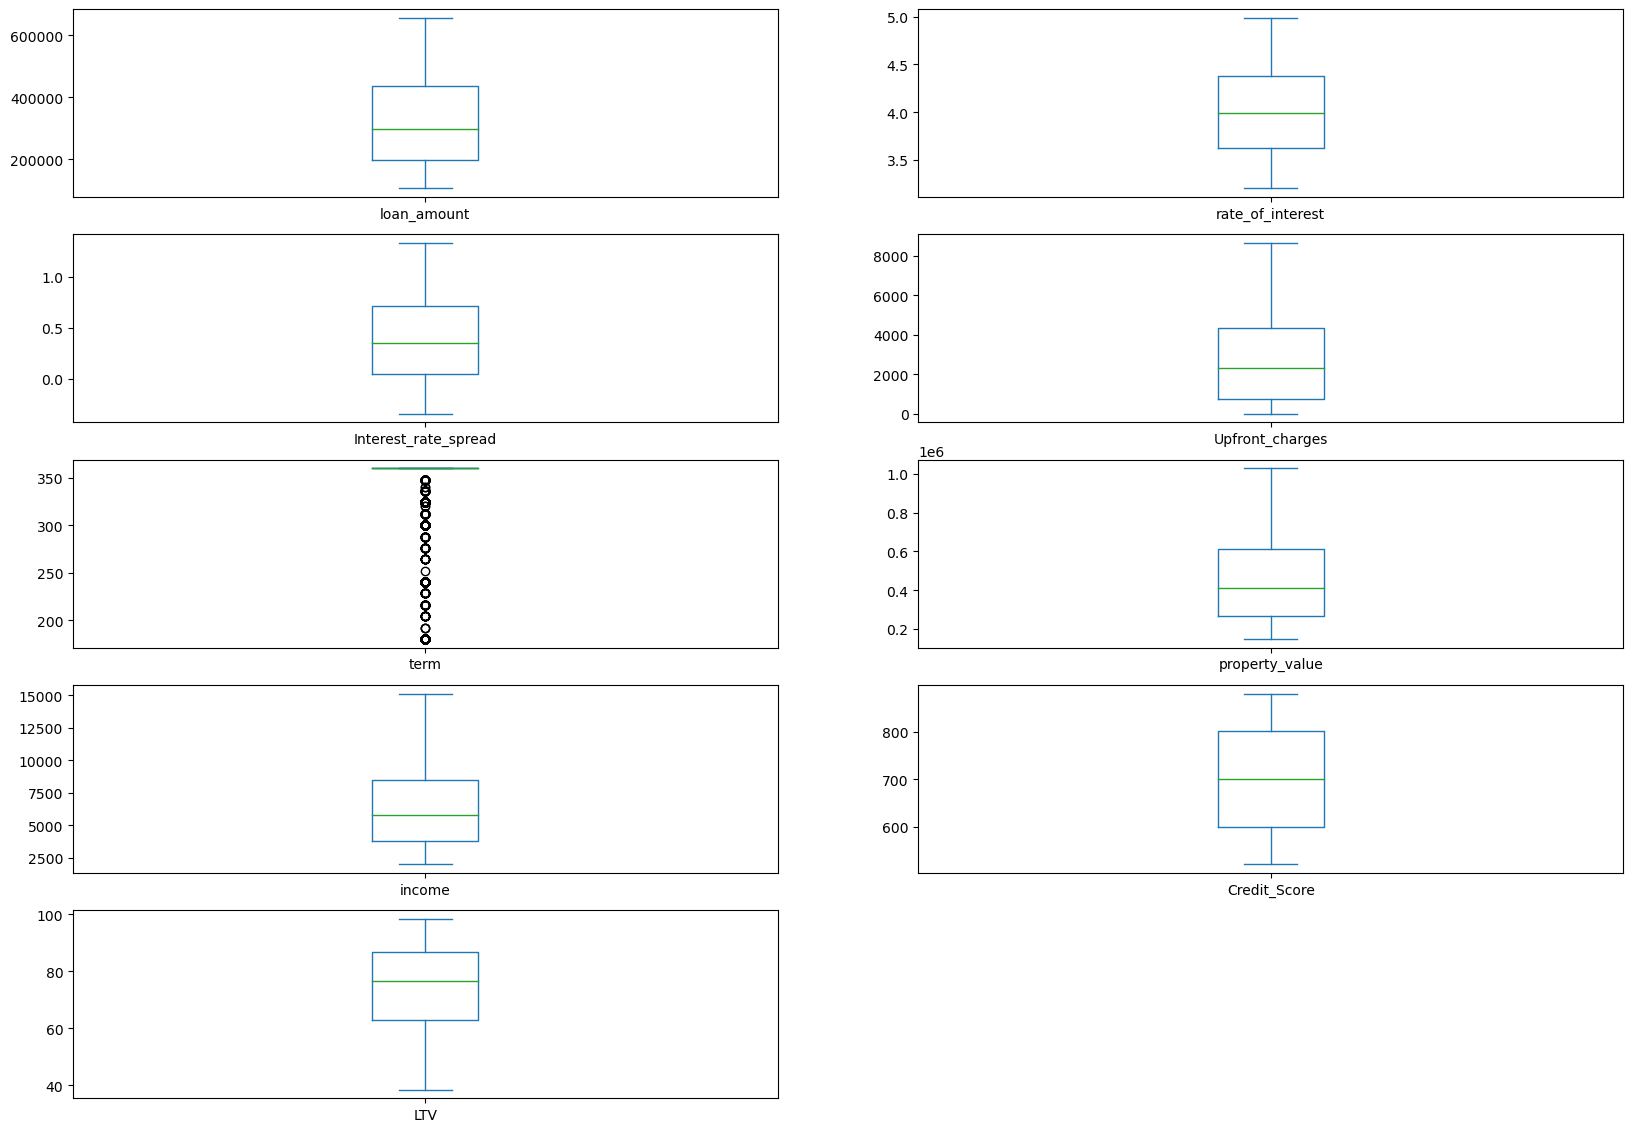

In [68]:
# Box plot after winsorizing
df_num_wins.plot(kind="box",subplots=True,layout=(7,2),figsize=(20,20))
plt.show()

In [69]:
# Checking number of outliers in the 'term' column
term_values = df_num_wins['term'].values.data
Q1 = np.quantile(term_values, 0.25)
Q3 = np.quantile(term_values, 0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_count = ((term_values < lower_bound) | (term_values > upper_bound)).sum()
print("Number of outliers in 'term' column:", outliers_count)

Number of outliers in 'term' column: 7309


In [70]:
# Since the number of outliers in the 'term' column is still large, we will winsorize it from 'df_num' again with 0.10 limits
df_num_wins['term'] = mstats.winsorize(df_num['term'], limits = [0.20, 0])

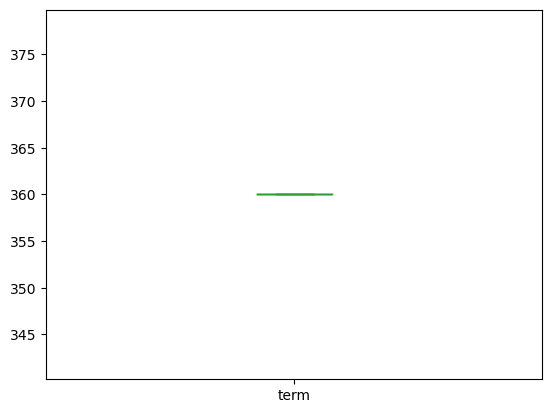

In [71]:
# Checking boxplot of the 'term' column again after winsorizing
df_num_wins['term'].plot(kind="box")
plt.show()

Thus, 'df_num_wins' is the final cleaned dataset with no null values or outliers.
Hence, we will now merge the cleaned categorical dataset, df_cat with df_num_wins to get the complete dataset of all features.

In [75]:
df_cat.shape

(40000, 21)

In [76]:
df_num_wins.shape

(40000, 9)

In [80]:
# Merging the categorical and numerical datasets together after cleaning
df_features = pd.concat([df_num_wins, df_cat], axis=1)
print(df_features.isnull().sum())
df_features.head()

loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
property_value               0
income                       0
Credit_Score                 0
LTV                          0
loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
credit_type                  0
co-applicant_credit_type     0
age                          0
submission_of_application    0
Region                       0
Security_Type                0
dtype: int64


,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,loan_limit,...,construction_type,occupancy_type,Secured_by,total_units,credit_type,co-applicant_credit_type,age,submission_of_application,Region,Security_Type
0,116500.0,3.458333,-0.091533,1327.413333,360.0,148000.0,1980.0,758.0,98.283154,0,...,1,1,0,0,3,0,0,1,3,1
1,206500.0,3.580000,0.029233,180.360000,360.0,258000.0,4980.0,552.0,82.142194,0,...,1,1,0,0,2,1,3,1,0,1
2,406500.0,4.560000,0.200000,595.000000,360.0,508000.0,9480.0,834.0,80.019685,0,...,1,1,0,0,3,0,1,1,3,1
3,456500.0,4.250000,0.681000,0.000000,360.0,658000.0,11880.0,587.0,69.376900,0,...,1,1,0,0,3,0,2,0,0,1
4,656500.0,4.000000,0.304200,0.000000,360.0,758000.0,10440.0,602.0,91.886544,0,...,1,1,0,0,1,1,0,0,0,1
